# 02 - Data from the Web


## You will never guess how long it takes EPFL students to complete their degree!

## (Question 2 will shock you!)

---

## Part 0 - Helpers and constants

#### Import modules

In [95]:
%matplotlib inline

import requests

from bs4 import BeautifulSoup

import re

import pickle

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')

#### Constants

In [2]:
# Base URL for isa.epfl.ch public report searches
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/'

#### Helpers

In [3]:
# Helper for creating search path
def isa_url(path):
    return isa_base_url + path

In [4]:
# Allow accessing dictionary items as object attributes
# https://goodcode.io/articles/python-dict-object/
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

In [5]:
# Fetch the given url using a GET requests with the supplied parameters
# and return a BeautifulSoup object
def get_page(url, params=None):
    r = requests.get(url, params)
    
     # Check whether the request succeeded or not
    if r.status_code is not requests.codes.ok:
        print("Something went wrong. Got status code = %d" % r.status_code)
        return None
    
    # Make sure we actually got some content back, as ISA will return a 200 status code but no content
    # when the supplied parameters are wrong.
    if int(r.headers['Content-Length']) == 0:
        print("Something went wrong. Got Content-Length: 0")
        return None
    
    # Extract the response body
    html = r.text
    
    # Parse it with BeautifulSoup
    return BeautifulSoup(html, 'html.parser')

## Part 1 - Scraper Module

The first step is to fetch all the data from ISA.

To do this, we will have to scrape the respective frames that ISA serves for the form and then the search results. Steps are detailed below.

In [6]:
# URL of the public ISA home page.
isa_home_url = isa_url('%21gedpublicreports.htm?ww_i_reportmodel=133685247')

#### Get the right frame URL from the home page

In [7]:
# Get the home page content
home_soup = get_page(isa_home_url)

In [8]:
# Find the frame containing the form
toc_frame = home_soup.find('frame', attrs={'name': 'toc'})

In [9]:
# Extract the frame's URL
toc_frame_url = toc_frame['src']
toc_frame_url

'!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247'

#### Let's now get the form itself

In [10]:
toc_url = isa_url(toc_frame_url)

In [11]:
toc_soup = get_page(toc_url)

In [12]:
# Find the form itself within the page.
# The form's name is a heuristic, read from the page's source.
form_elem = toc_soup.find('form', attrs={'name': 'f'})

In [13]:
# Find the form's action on validation
form_action = form_elem['action']
form_action_url = isa_url(form_action)
form_action_url

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'

### Manually craft the same request submitting the form would send to the server

The requests below corresponds to:

**Format:** html  
**Unité academique:** Informatique  
**Période académique:** *blank*  
**Période pédagogique:** *blank*  
**Type de semestre:** *blank*  

In [14]:
# Define a payload dictionary with all the parameters expected by ISA's API endpoint

# /!\ By default we will request all possibilities from the endpoint, and then filter. /!\ #

# Example requests for specific academic or pedagogic periods are left FYI.

payload = {
    'ww_b_list': '1',
    'ww_i_reportmodel': '133685247',
    'ww_c_langue': '',
    
    # Format = html
    'ww_i_reportModelXsl': '133685270', 
    
    # Faculty = { Informatique : 249847 }
    'zz_x_UNITE_ACAD': 'Informatique',
    'ww_x_UNITE_ACAD': '249847',
    
    # Academic Period = { '' : null } if we want all possible periods
    #                 = { '2016-2017' : 355925344 } for a specific year
    'zz_x_PERIODE_ACAD': '',
    'ww_x_PERIODE_ACAD': 'null',

    
    # Pedagogic Period = { '' : null } if we want all possible periods
    #                  = { 'Bachelor semestre 1' : 249108 } for a specific period
    'zz_x_PERIODE_PEDAGO': '',
    'ww_x_PERIODE_PEDAGO': 'null',
    
    # Winter or summer semesters
    'zz_x_HIVERETE': '',
    'ww_x_HIVERETE': 'null',
    
    'dummy': 'ok'
}

#### Send the request and extract the list of links that would appear below the form had we submitted it using the browser

In [15]:
# Parse the result
form_result_soup = get_page(form_action_url, params=payload)
# form_result_soup.prettify() # Debug print

In [16]:
# Extract the links from the list of results
all_links = form_result_soup('a', class_='ww_x_GPS')
# all_links # Debug print

Store the links in a dictionary. Some cleaning is applied, such as whitespace stripping

> **Note:** We remove the first link, named 'Tous', as we will request each page individually
      in order to avoid downloading a huge HTML table, which would also be much more painful to parse.

In [17]:
links = [
    objdict({
        'text': link.text.strip(),
        'url': link.attrs['onclick']
    }) for link in all_links if link.text.strip() != 'Tous'
]

For each link,the page loads the respective results with the following on-click action :

```
loadReport('ww_x_GPS=2021043255');return false;
```

We will use the following function ```parse_url()``` to extract the ```ww_x_GPS``` parameter expected by the API to return the desired information about the students.

In [18]:
parse_url_pattern = r"""'(\w+)=(\d+)'"""
parse_url_re = re.compile(parse_url_pattern)

def parse_url(url):
    match = re.search(parse_url_pattern, url)

    if match == None:
        print('parse_url: parsing failure: %s' % url)
        return None
    
    return objdict({
        'key': match.group(1),
        'value': match.group(2)
    })

The list itself must be parsed to extract information regarding section, academic year, pedagogic period. The format is the following :

```
Informatique, 2016-2017, Bachelor semestre 1
```

We call an element of the list an item, and it will be parsed by the following ```parse_item()``` function.

In [41]:
parse_item_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*(?P<degree>[\w]+) semestre (?P<semester>\d)"""
parse_item_re = re.compile(parse_item_pattern)

def parse_item(item, url, payload):
    match = re.match(parse_item_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        # print('Match failed: %s ' % item)
        return None
    
    parsed_url = parse_url(url)
    
    if parsed_url == None:
        return None
    
    params = payload.copy()
    params[parsed_url.key] = parsed_url.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'degree': match.group('degree'),
        'semester': int(match.group('semester')),
        'params': params
    })

def show_item(item):
    if 'degree' in item:
        return ('%s semester %s (%d-%d)' % (item.degree, item.semester, item.start_year, item.end_year))
    else:
        return ('Master project, %s semester (%d-%d)' % (item.season, item.start_year, item.end_year))

# Filter all None elements from the given list
def filter_none(a_list):
    return [item for item in a_list if item != None]

Let's now parse all the links, and extract the URL parameter we will need to fetch the corresponding page:

In [20]:
all_items = [parse_item(link.text, link.url, payload) for link in links]

We only one to fetch the students who started after 2007 and end their master before 2017:

In [21]:
def is_valid_item(item):
    return item != None and item.start_year >= 2007 and item.end_year <= 2017

def filter_items(items):
    return [item for item in items if is_valid_item(item)]

In [22]:
items = filter_items(all_items)

#### Let's now go through all the collected items to extract the list of enrolled students

In [23]:
list_page_url = isa_url('!GEDPUBLICREPORTS.html')

# Parse a row of the table into a dictionary, keeping all cells,
# and adding the information about the degree and semester.
def parse_student_row(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['degree', 'semester', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

# Extract all students from the given page, that was fetched with the given item
def parse_students_list(page_soup, item):
    table = page_soup.find('table')
    trs = table.find_all('tr')
    
    # If the table has less than 3 rows, it doesn't contain any students
    if len(trs) < 3:
        return []
    
    (header_row, students_rows) = (trs[1], trs[2:])
        
    headers = [x.text for x in header_row.find_all('th')]
    
    return [
        parse_student_row(student_row, item, headers) for student_row in students_rows
    ]

# Load and extract all students in the page characterized by the given item.
def load_student_page(item):
    print('Loading page for "%s"' % show_item(item))
    
    return objdict({
        'soup': get_page(list_page_url, item.params),
        'item': item
    })

# Flatten a list of list into a list.
def flatten_list(a_list):
    return [item for sublist in a_list for item in sublist]

In [24]:
# Set this flag to False to load the data from ISA
load_from_disk = True
save_path = "students_data.p"

if load_from_disk:
    student_list = pickle.load(open(save_path, 'rb'))
else:
    students_pages = [load_student_page(item) for item in items]

    students_lists = [
        parse_students_list(page.soup, page.item) for page in students_pages
    ]

    student_list = flatten_list(students_lists)
    
    # Serialize the whole data to disk
    pickle.dump(student_list, open(save_path, 'wb'))

## Part 2 - Data analysis

### Question 1

> Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

Let's load all students, and clean up the columns names for easier subsequent manipulation:

In [25]:
students_data = pd.DataFrame(student_list)

def load_bsc_data(data):
    bsc_data = students_data[['No Sciper', 'Civilité', 'Nom Prénom', 'degree', 'semester', 'start_year', 'end_year']]
    return bsc_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name'})
    
bsc_data = load_bsc_data(students_data)

We only want to keep Bachelor students for whom we have an entry for both semester 1 and 6:

In [26]:
def filter_bsc_students(bsc_data):
    bsc_students = bsc_data[bsc_data['degree'] == 'Bachelor']
    idx1 = set(bsc_students[bsc_students['semester'] == 1].set_index('sciper').index)
    idx6 = set(bsc_students[bsc_students['semester'] == 6].set_index('sciper').index)

    idx = idx1.intersection(idx6)

    return bsc_students[bsc_students['sciper'].isin(idx)].set_index('sciper').sort_index()

bsc = filter_bsc_students(bsc_data)
bsc.head(20)

,title,name,degree,semester,start_year,end_year
sciper,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008


We now compute the number a semester each student did, and add it as a column.
We do so by computing the number of rows we have per student (TODO: Ensure we don't have duplicated rows)

In [27]:
def add_semesters_count(bsc):
    cols = ['sciper', 'semester']
    semester_count = bsc.reset_index()[cols].groupby('sciper').count().rename(columns={'semester': 'semester_count'})
    return bsc.merge(semester_count, left_index=True, right_index=True)
    
bsc_with_count = add_semesters_count(bsc)
bsc_with_count.head(20)

,title,name,degree,semester,start_year,end_year,semester_count
sciper,,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011,6
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011,6
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008,6


We now group rows by SCIPER, to only get one row per student. Since we're only interested in the SCIPER, name, and semster count, which are identical for all rows concerning a given student, we can safely take the first row per student.

In [28]:
bsc_agg = bsc_with_count[['title', 'name', 'semester_count']].reset_index().groupby('sciper').agg('first')
bsc_agg.sample(10)

,title,name,semester_count
sciper,,,
226312,Monsieur,Bordenca Tobias,8
179428,Monsieur,Barroco Michael,8
203099,Monsieur,Dorsaz Adrien Michel Denis,8
201600,Monsieur,Grütter Karl Samuel,6
217661,Monsieur,Girard Matthieu Pierre,8
196683,Monsieur,Vostriakov Alexander,10
169569,Monsieur,Arévalo Christian,6
246671,Monsieur,Abate Bryan Jeremy,6
203447,Monsieur,Matter Valentin Nicolas,6


Let's now filter students who did less than 6 semesters, as those either haven't completed their BSc
or are outliers who switched sections or something else.

In [29]:
len(bsc_agg[bsc_agg['semester_count'] < 6])

1

In [30]:
bsc_agg_filtered = bsc_agg[bsc_agg['semester_count'] >= 6]
bsc_agg_filtered.describe()

,semester_count
count,396.000000
mean,7.090909
std,1.518433
min,6.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [96]:
by_title = bsc_agg.groupby('title')
by_title['semester_count'].describe()

title          
Madame    count     29.000000
          mean       6.793103
          std        1.346406
          min        6.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       11.000000
Monsieur  count    368.000000
          mean       7.105978
          std        1.536891
          min        4.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       12.000000
Name: semester_count, dtype: float64

### Testing the average duration between male (M) and female (F) students

In [100]:
# Import stats lib for t-test
from scipy import stats

Let us start by grouping the values into male (M) and female (F) groups

In [102]:
M = by_title.get_group('Monsieur')['semester_count']
F = by_title.get_group('Madame')['semester_count']

The mean values are given by:

In [104]:
print('Mean duration for male students = {}'.format(M.mean()))
print('Mean duration for female students = {}'.format(F.mean()))

Mean duration for male students = 7.105978260869565
Mean duration for female students = 6.793103448275862


Though through intuitively we would conclude that the duration is not the same on average, we will conduct a t-test to prove the null hypothesis H0 :

> **H0** -- The mean duration for male and female students is the same

To test this hypothesis we will use **Welch's t-test**, which is a Student t-test for data with different variances. Welch’s t-test does not pool the standard deviations, but divides the variance in each group by the size of that group. We will have a two-tailed t-test since means can be higher or lower if the null hypothesis is disproved.

In [105]:
delta_variance = (M.var() - F.var()) # Check that the variances are not equal (justifying Welch's t-test)
tol = 1e-6 # Under this tolerance the difference is not significative

(t_statistic, p_value) = stats.ttest_ind(M, F, equal_var = delta_variance < tol)
print('We find a statistic t = {}, with a p-value = {}'.format(t_statistic, p_value))

We find a statistic t = 1.191705695448116, with a p-value = 0.24162457057331926


We have found a high p-value (almost 25%) which means we can reject the null hypothesis and conclude that 
**there is indeed a difference between the average duration of bachelor study between males and females**.

### Question 2

> Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [36]:
def load_msc_data(data):
    cols = [
        'Civilité', 'No Sciper', 'Nom Prénom', 'Statut',
        'Spécialisation', 'Mineur',
        'degree', 'semester', 'end_year', 'start_year'
    ]
    rename = {
        'Civilité': 'title',
        'No Sciper': 'sciper',
        'Nom Prénom': 'name',
        'Statut': 'status',
        'Spécialisation': 'specialisation',
        'Mineur': 'minor'
    }
    
    return students_data[cols].rename(columns=rename)
    
msc_data = load_msc_data(students_data)

def filter_msc_students(students_data):
    return students_data[(students_data['degree'] == 'Master') & (students_data['status'] == 'Présent')]

msc = filter_msc_students(msc_data).set_index('sciper').sort_index()
msc.sample(10)

,title,name,status,specialisation,minor,degree,semester,end_year,start_year
sciper,,,,,,,,,
199252,Monsieur,Petropavlov Kirill,Présent,,,Master,1,2011,2010
153664,Monsieur,Brandinu Guillaume,Présent,"Signals, Images and Interfaces",,Master,3,2008,2007
175503,Monsieur,Favre Ludovic,Présent,,,Master,1,2010,2009
221295,Monsieur,Jichi Rida,Présent,,,Master,1,2013,2012
216690,Monsieur,Roulin Andy,Présent,Computer Engineering - SP,,Master,2,2016,2015
245293,Madame,Zhang Jin,Présent,,,Master,1,2015,2014
200065,Madame,Bogos Sonia Mihaela,Présent,,,Master,2,2011,2010
195446,Monsieur,Simond Florian,Présent,,,Master,1,2014,2013
161402,Monsieur,Suter Philippe Paul Henri,Présent,Foundations of Software,,Master,3,2008,2007


In [33]:
msc_count = add_semesters_count(msc)
msc_count[(msc_count['semester_count'] < 3) & (msc_count['minor'] != '')]

,title,name,status,specialisation,minor,degree,semester,end_year,start_year,semester_count
sciper,,,,,,,,,,
153642,Monsieur,Imhoff Lionel,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
153645,Monsieur,Rosat Damien,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
160391,Monsieur,Chipounov Vitaly,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
172257,Monsieur,Dubut Frédéric,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
199294,Monsieur,Jin Xuedong,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
199294,Monsieur,Jin Xuedong,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2012,2011,2
200419,Monsieur,Jing Lifu,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
203301,Monsieur,Nishida Keishi,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
203301,Monsieur,Nishida Keishi,Présent,,"Mineur en Management, technologie et entrepren...",Master,1,2011,2010,2


In [72]:
msc_agg = msc_count[['title', 'name', 'minor', 'specialisation', 'semester_count']].reset_index().groupby('sciper').agg('first')
msc_agg.sample(10)

,title,name,minor,specialisation,semester_count
sciper,,,,,
223241,Monsieur,Note Théodore André Laurent Christophe,,,3
238428,Madame,Da Silva Alves Elizabeth,,Service science,3
269467,Monsieur,Shevchenko Artem,,,1
193484,Monsieur,Küng Roger,,,3
196896,Monsieur,Kebets Ilia,,,2
258813,Madame,Popovych Olga,,,1
259573,Monsieur,Hottinger Jeremy,,,1
227942,Monsieur,Kapp Hugo Stéphane,,Foundations of Software,3
192899,Monsieur,Monnier Alex,,,2


In [73]:
msc_agg[msc_agg['semester_count'] >= 1].groupby('title').describe()

semester_count
title                         
Madame   count      131.000000
         mean         2.503817
         std          1.098069
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          7.000000
Monsieur count      834.000000
         mean         2.482014
         std          1.004330
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          6.000000

We now load all the data from the 'Master project' tables, hoping that it will provide us with reliable info on when a student successfully completed their degree. We indeed assume here that being registered for the Master project is a good indication that a student has passed all their classes, and got their degree after the project.

In [74]:
parse_item_pdm_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*Projet Master\s+(?P<season>\w+)"""
parse_item_pdm_re = re.compile(parse_item_pdm_pattern)

def parse_item_pdm(item, url, payload):
    match = re.match(parse_item_pdm_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        # print('Match failed: %s ' % item)
        return None
    parsed_url = parse_url(url)
    
    if parsed_url == None:
        return None
    
    params = payload.copy()
    params[parsed_url.key] = parsed_url.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'season': match.group('season'),
        'params': params
    })


all_items_pdm = [parse_item_pdm(link.text, link.url, payload) for link in links]
items_pdm = filter_items(all_items_pdm)

In [75]:
def parse_student_row_pdm(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['season', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

def parse_students_list_pdm(page_soup, item):
    table = page_soup.find('table')
    trs = table.find_all('tr')
    
    if len(trs) < 3:
        return []
    
    (header_row, students_rows) = (trs[1], trs[2:])
        
    headers = [x.text for x in header_row.find_all('th')]
    
    return [
        parse_student_row_pdm(student_row, item, headers) for student_row in students_rows
    ]

In [76]:
# Set this flag to False to load the data from ISA
pdm_load_from_disk = True
pdm_save_path = "pdm_data.p"

if pdm_load_from_disk:
    student_list_pdm = pickle.load(open(pdm_save_path, 'rb'))
else:
    pdm_students_pages = [load_student_page(item) for item in items_pdm]

    students_lists_pdm = [
        parse_students_list_pdm(page.soup, page.item) for page in pdm_students_pages
    ]

    student_list_pdm = flatten_list(students_lists_pdm) 
    
    # Serialize the whole data to disk
    pickle.dump(student_list_pdm, open(pdm_save_path, 'wb'))

In [77]:
students_pdm_data = pd.DataFrame(student_list_pdm)
students_pdm_data.sample(10)

def load_pdm_data(data):
    pdm_data = students_pdm_data[['No Sciper', 'Civilité', 'Nom Prénom', 'Mineur', 'Statut', 'start_year', 'end_year','season']]
    return pdm_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name'})
    
pdm_data = load_pdm_data(students_pdm_data)

pdm_data = pdm_data.set_index('sciper').sort_index()
pdm_data.index.is_unique

False

In [78]:
pdm_data.index.get_duplicates()

['146742', '159852', '160213', '170235', '173527', '183605', '191471']

In [79]:
pdm_data.reset_index()[pdm_data.reset_index()['sciper'].isin(pdm_data.index.get_duplicates())]

,sciper,title,name,Mineur,Statut,start_year,end_year,season
1,146742,Monsieur,Marx Clément,,Présent,2010,2011,automne
2,146742,Monsieur,Marx Clément,,Congé,2010,2011,printemps
6,159852,Monsieur,Brutsche Florian,,Congé,2007,2008,printemps
7,159852,Monsieur,Brutsche Florian,,Congé,2008,2009,automne
9,160213,Monsieur,Bécholey Alexandre,,Congé,2009,2010,printemps
10,160213,Monsieur,Bécholey Alexandre,,Présent,2009,2010,automne
19,170235,Monsieur,Gruner Samuel,,Congé,2011,2012,printemps
20,170235,Monsieur,Gruner Samuel,,Présent,2012,2013,automne
29,173527,Monsieur,Stewart Conail,,Présent,2007,2008,automne
30,173527,Monsieur,Stewart Conail,,Présent,2007,2008,printemps


In [80]:
msc_agg_pdm = msc_agg.sort_index()
pdm_data = pdm_data.reset_index().drop_duplicates(subset='sciper').set_index(['sciper'])
msc_agg_pdm[['PDM Statut','PDM_start_y','PDM_end_y','season']] = pdm_data[['Statut','start_year','end_year','season']]
msc_agg_pdm = msc_agg_pdm.fillna('').sort_index()

In [81]:
msc_agg_pdm[(msc_agg_pdm['PDM_end_y'] != '')].sample(10)

,title,name,minor,specialisation,semester_count,PDM Statut,PDM_start_y,PDM_end_y,season
sciper,,,,,,,,,
200808,Monsieur,Pesic Dimitrije,,,2,Stage,2011,2012,automne
214637,Monsieur,Bovet Sidney,,Internet computing,3,Présent,2016,2017,automne
145957,Monsieur,Hügli Michael,,,1,Stage,2007,2008,printemps
260811,Monsieur,Loiseleur Thibaut,,,2,Présent,2016,2017,automne
179670,Monsieur,Perrenoud Basile Samuel,,,3,Stage,2011,2012,printemps
194328,Monsieur,El Houti Youssef,,,4,Présent,2016,2017,automne
244283,Madame,Zaridze Ketevani,,,3,Présent,2016,2017,automne
259910,Monsieur,Rousseau Adrien Jean-Louis,,,2,Présent,2016,2017,automne
194182,Monsieur,Antognini Marco,,Foundations of Software,4,Présent,2016,2017,automne


In [82]:
msc_agg_pdm[(msc_agg_pdm['PDM_end_y'] != '')].groupby('title').describe()

semester_count
title                         
Madame   count       13.000000
         mean         2.692308
         std          0.854850
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000
Monsieur count      107.000000
         mean         2.803738
         std          0.840477
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000

Sadly, with only 107+13=120 entries, this data set is way too sparse to actually provide any useful information. Let's then keep working with the original data set only.

We will now clean up the data set a bit by only keeping students who did at least two semesters, and removing the ones who are registered with a minor or a specialisation but have a semester count smaller than 3.

In [83]:
not_enough_semesters = (msc_agg['semester_count'] < 3) & ((msc_agg['specialisation'] != '') | (msc_agg['minor'] != ''))
less_than_two        = msc_agg['semester_count'] < 2

msc_agg_valid = msc_agg[~(not_enough_semesters | less_than_two)]
msc_agg_valid = msc_agg_valid.reset_index().groupby('sciper').agg('first')

In [108]:
msc_agg_valid.groupby('title').describe()

semester_count
title                         
Madame   count      102.000000
         mean         2.901961
         std          0.895642
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          7.000000
Monsieur count      644.000000
         mean         2.885093
         std          0.749802
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          6.000000

#### Average stay at EPFL for master students

In [109]:
msc_agg = msc_agg[msc_agg['semester_count'] >= 1]
avg_stay_masters = msc_agg.mean()
print('The average stay for masters students at EPFL is {} semesters'.format(avg_stay_masters['semester_count']))

The average stay for masters students at EPFL is 2.4849740932642486 semesters


### Breakdown per specialisation

Let's now see whether the choice of specialisation has any influence on the number of semesters a student stays at EPFL:

In [87]:
with_specialisation = msc_agg_valid['specialisation'] != ''
msc_agg_spe = msc_agg_valid[with_specialisation]
msc_agg_spe.sample(10)

,title,name,minor,specialisation,semester_count
sciper,,,,,
147008,Monsieur,Good Xavier,,"Signals, Images and Interfaces",3
212790,Monsieur,Engilberge Martin Pierre,,Internet computing,3
176061,Monsieur,Ecuyer Adrien,,Internet computing,3
171028,Monsieur,Neu Raoul,,Internet computing,3
201034,Monsieur,Kashani-Akhavan Sahand,,Computer Engineering - SP,5
177399,Monsieur,Heath Quentin,,Foundations of Software,3
186833,Monsieur,Sanchez Witt Carlos,,"Signals, Images and Interfaces",4
254809,Monsieur,Lahoud Fayez,,"Signals, Images and Interfaces",3
159998,Madame,Jesse Julia,,"Signals, Images and Interfaces",3


In [111]:
msc_by_spe = msc_agg_spe.reset_index().groupby(['specialisation'])
msc_by_spe.describe()

semester_count
specialisation                                      
Biocomputing                   count        3.000000
                               mean         3.666667
                               std          1.154701
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          4.000000
                               max          5.000000
Computer Engineering - SP      count       13.000000
                               mean         3.384615
                               std          0.767948
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          3.000000
                               max          5.000000
Data Analytics                 count        4.000000
                               mean         3.000000
                               std          0.000000
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          3.000000
                               max          3.000000
Foundations of Software        count       44.000000
                               mean         3.386364
                               std          0.492545
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
...                                              ...
Internet computing             std          0.679068
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          4.000000
                               max          6.000000
Service science                count        3.000000
                               mean         3.333333
                               std          0.577350
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          3.500000
                               max          4.000000
Signals, Images and Interfaces count       19.000000
                               mean         3.789474
                               std          0.854982
                               min          3.000000
                               25%          3.000000
                               50%          4.000000
                               75%          4.000000
                               max          6.000000
Software Systems               count        9.000000
                               mean         3.222222
                               std          0.440959
                               min          3.000000
                               25%          3.000000
                               50%          3.000000
                               75%          3.000000
                               max          4.000000

[80 rows x 1 columns]

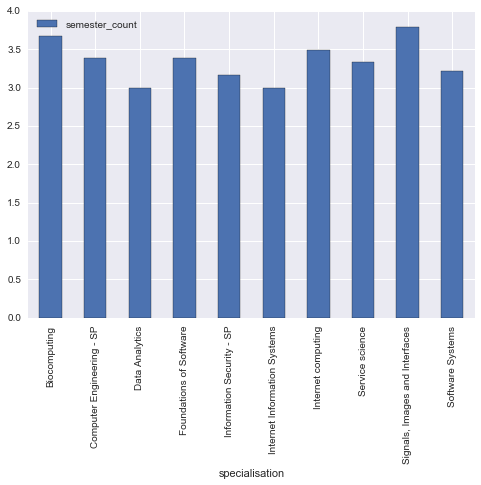

In [93]:
msc_by_spe.mean().plot(kind = 'bar')

To find statistical differences in this means we will use an F-test for one-way ANOVA, with the null hypothesis H0
> H0 -- The mean stay for all specialisations is the same

We will assume the following hypotheses to be true:
* Each population is normally distributed
* Independent samples from the populations
* Equal population standard deviations

In [114]:
msc_spe = msc_agg_valid.reset_index()[['specialisation', 'semester_count']].set_index('specialisation').sort_index()

In [116]:
msc_spe_gp = msc_agg_valid.reset_index()[['specialisation', 'semester_count']].groupby('specialisation')
msc_gp = [msc_spe_gp.get_group(g)['semester_count'] for g in msc_spe_gp.groups]

In [117]:
# TODO ! Check, not 100% sure it works ...
# spe1 = [n_semesters1, n_semesters2, ...]
# stats.f_oneway(spe1, spe2, ...)
stats.f_oneway(*msc_gp) # equivalent to apply(stats.f_oneway, *args)

F_onewayResult(statistic=13.578419153196668, pvalue=4.3023241717364409e-22)

### Bonus
> Perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

In [118]:
msc = msc_count[['title', 'name', 'semester_count']].reset_index().groupby('sciper').agg('first')
msc_by_title = msc.groupby('title')
msc_by_title['semester_count'].describe()

title          
Madame    count    131.000000
          mean       2.503817
          std        1.098069
          min        1.000000
          25%        2.000000
          50%        3.000000
          75%        3.000000
          max        7.000000
Monsieur  count    834.000000
          mean       2.482014
          std        1.004330
          min        1.000000
          25%        2.000000
          50%        3.000000
          75%        3.000000
          max        6.000000
Name: semester_count, dtype: float64

In [119]:
M_msc = msc_by_title.get_group('Monsieur')['semester_count']
F_msc = msc_by_title.get_group('Madame')['semester_count']

In [120]:
print('Mean duration for male students = {}'.format(M_msc.mean()))
print('Mean duration for female students = {}'.format(F_msc.mean()))

Mean duration for male students = 2.4820143884892087
Mean duration for female students = 2.50381679389313


In [121]:
delta_variance = (M_msc.var() - F_msc.var()) # Check that the variances are not equal (justifying Welch's t-test)
tol = 1e-6 # Under this tolerance the difference is not significative

(t_statistic_msc, p_value_msc) = stats.ttest_ind(M_msc, F_msc, equal_var = delta_variance < tol)
print('We find a statistic t = {}, with a p-value = {}'.format(t_statistic_msc, p_value_msc))

We find a statistic t = -0.22799730652686717, with a p-value = 0.8196967344880302
